In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

from utils import *

plt.style.use('ggplot')

## Data loading

In [63]:
data_URL = 'https://www.ssb.no/statbank/sq/10085910'

data = import_salmon_data(data_URL)

# Change index to datetime format
date_series = pd.to_datetime(data['uke'].str[:4] + data['uke'].str[-2:] + '1', format='%Y%W%w')
data.set_index(date_series, inplace=True)
data.drop(['uke'], axis=1, inplace=True)

add_lags(data)

display(data)

,Kilopris (kr),Vekt (tonn),Year,Week,Month,Day of year
uke,,,,,,
2000-01-10,31.12,4054,2000,2,1,10
2000-01-17,31.03,4043,2000,3,1,17
2000-01-24,30.95,3730,2000,4,1,24
2000-01-31,31.30,3831,2000,5,1,31
2000-02-07,32.53,4415,2000,6,2,38
...,...,...,...,...,...,...
2023-07-24,86.14,19604,2023,30,7,205
2023-07-31,83.28,20469,2023,31,7,212
2023-08-07,80.26,21060,2023,32,8,219


## Model training

In [64]:

features = ['Year', 'Week', 'Month', 'Day of year']
targets = ['Vekt (tonn)', 'Kilopris (kr)']

tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store evaluation results
test_loss_scores = []

# Create and train the model for each fold in the time series split
for train_index, test_index in tscv.split(data):
    X_train, X_test = data[features].iloc[train_index], data[features].iloc[test_index]
    y_train, y_test = data[targets].iloc[train_index], data[targets].iloc[test_index]
    
    model = Sequential([
        SimpleRNN(200, input_shape=(4, 1), activation="relu"), Dense(252),
        Dense(2)
    ])
    
    model.compile(loss="mse", optimizer="adam")
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))
    
    test_loss = model.evaluate(X_test, y_test)
    test_loss_scores.append(test_loss)


Epoch 1/50
13/13 [==============================] - 3s 38ms/step - loss: 8406716.0000 - val_loss: 1977217.2500
Epoch 2/50
13/13 [==============================] - 0s 11ms/step - loss: 1564997.7500 - val_loss: 6325281.5000
Epoch 3/50
13/13 [==============================] - 0s 10ms/step - loss: 928437.2500 - val_loss: 5777445.0000
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 888494.0625 - val_loss: 4453065.5000
Epoch 5/50
13/13 [==============================] - 0s 12ms/step - loss: 802783.3125 - val_loss: 4646191.0000
Epoch 6/50
13/13 [==============================] - 0s 11ms/step - loss: 796279.0000 - val_loss: 4982112.0000
Epoch 7/50
13/13 [==============================] - 0s 11ms/step - loss: 805677.5625 - val_loss: 4645194.5000
Epoch 8/50
13/13 [==============================] - 0s 11ms/step - loss: 790583.2500 - val_loss: 5430500.5000
Epoch 9/50
13/13 [==============================] - 0s 12ms/step - loss: 781688.1250 - val_loss: 4403883.5000
Epoch 10

## Model prediction

Fold 1 - Test Loss: 5204098.5000
Fold 2 - Test Loss: 14698030.0000
Fold 3 - Test Loss: 29463870.0000
Fold 4 - Test Loss: 19284912.0000
Fold 5 - Test Loss: 29128098.0000


27/27 [==============================] - 0s 4ms/step


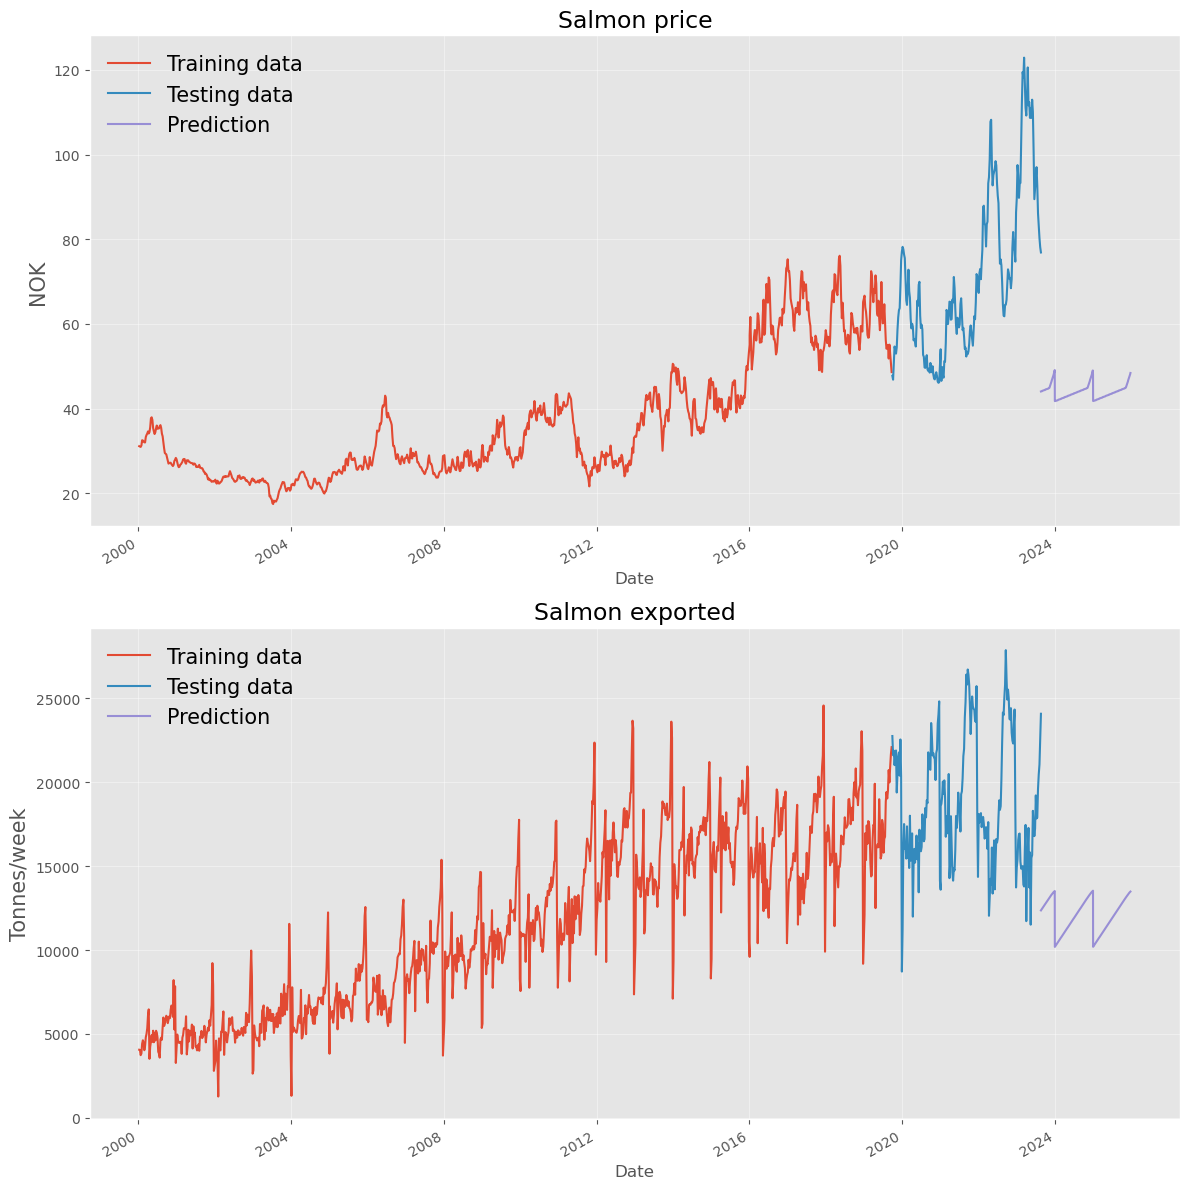

In [65]:
# Print the evaluation results for each fold
for i, test_loss in enumerate(test_loss_scores):
    print(f"Fold {i+1} - Test Loss: {test_loss:.4f}")

future_dates = pd.DataFrame(
    pd.date_range(
        start=data.index[-1], 
        end='2025-12-24'
    ), columns=['Date']
)

future_dates.set_index(future_dates['Date'], inplace=True)
add_lags(future_dates)
future_dates.drop('Date', axis=1, inplace=True)


predictions = pd.DataFrame(model.predict(future_dates), columns=targets, index=future_dates.index)


fig, axs = plt.subplots(2, figsize=(12, 12))

data_types = ['Training data', 'Testing data', 'Prediction']
label = ['NOK', 'Tonnes/week']
title = ['Salmon price', 'Salmon exported']

for i, target in enumerate(['Kilopris (kr)', 'Vekt (tonn)']):
    for j, data in enumerate([y_train, y_test, predictions]):
        data[target].plot(ax=axs[i], label=data_types[j])
        axs[i].legend(fontsize=15, frameon=False)
        axs[i].grid(alpha=0.4)
        axs[i].set_ylabel(label[i], fontsize=15)
        axs[i].set_title(title[i], fontsize=17)

fig.tight_layout()

# # Week 43:
# print('Week 43:')
# display(pd.DataFrame(predictions.loc['2023-10-23']))